## Purpose

This code is designed to generate synthetic data with more random characterics than is provided by the BMS dataset. This could be used to aid the robustness of algorithms created to tackle the BMS task and other related tasks.

For the background disussion, refer to: https://www.kaggle.com/c/bms-molecular-translation/discussion/225590 .

Updates for the 2nd edition:
  - resulting outpus are closer to the original dataset
  - support InChI inputs (not just SMILES)
  - font scaling now actually works (in the previous version, additional random diagram scaling made it look as if font scaling was working)
  - replaced hacky SVG manipulation code for dropping bonds and changing fonts with code using lxml
  - outputs also include the unaugmented image, given in two layers: one for the atoms and one for the bonds
  - result are shown actual size and compared with image from the original dataset.
 
Updates for 3rd edition:
  - a slight tweak to stretch the value range of output values of the (unaugmented) atom and bond images to fit exactly in the range 0 to 1

In [1]:
#!pip -q install cairosvg==2.5.2
#!pip -q install reportlab==3.5.65
#!pip -q install cssutils==2.2.0

In [2]:
print('Installing RDKit. This can take a while ...')
# We use a specific version of RDKit with known working font scaling.
#!conda config --append channels conda-forge
#!conda install -q -y -c rdkit rdkit=2020_03_6
print('DONE.')

Installing RDKit. This can take a while ...
DONE.


In [3]:
from pathlib import Path
from io import BytesIO
import re
import copy
import logging
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import lxml.etree as et
import cssutils

from PIL import Image
import cairosvg
from skimage.transform import resize

import IPython
from IPython.display import SVG
from IPython.display import display
import ipywidgets as widgets
from matplotlib import pyplot as plt

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import MolDrawOptions

In [4]:
PROJECT_DIR = Path('..')
INPUT_DIR = PROJECT_DIR / 'data'
TMP_DIR = PROJECT_DIR / 'tmp'
TRAIN_DATA_PATH = INPUT_DIR / 'train'
TARGET_DIR = 'synthetic_train'
SAVE_DATA_PATH = INPUT_DIR / TARGET_DIR
TRAIN_LABELS_PATH = INPUT_DIR / 'train_labels.csv'
TMP_DIR.mkdir(exist_ok=True)

cssutils.log.setLevel(logging.CRITICAL)

np.set_printoptions(edgeitems=30, linewidth=180)
print('RDKit version:', rdkit.__version__)
# Use a specific version of RDKit with known characteristics so that we can reliably manipulate output SVG.
assert rdkit.__version__ == '2020.03.6'

TRAIN_LABELS = pd.read_csv(TRAIN_LABELS_PATH)
print(f'Read {len(TRAIN_LABELS)} training labels.')

RDKit version: 2020.03.6
Read 2424186 training labels.


## Implementation

We vary the drawing properties, the font, and occassionally drop bond lines.

In [5]:
def one_in(n):
    return np.random.randint(n) == 0 and True or False


def yesno():
    return one_in(2)


def svg_to_image(svg, convert_to_greyscale=True):
    svg_str = et.tostring(svg)
    # TODO: would prefer to convert SVG dirrectly to a numpy array.
    png = cairosvg.svg2png(bytestring=svg_str)
    image = np.array(Image.open(BytesIO(png)), dtype=np.float32)
    # Naive greyscale conversion.
    if convert_to_greyscale:
        image = image.mean(axis=-1)
    return image


def elemstr(elem):
    return ', '.join([item[0] + ': ' + item[1] for item in elem.items()])


# Streches the value range of an image to be exactly 0, 1, unless the image appears to be blank.
def stretch_image(img, blank_threshold=1e-2):
    img_min = img.min()
    img = img - img_min
    img_max = img.max()
    if img_max < blank_threshold:
        # seems to be blank or close to it
        return img
    img_max = img.max()
    if img_max < 1.0:
        img = img/img_max
    return img


def random_molecule_image(inchi, drop_bonds=True, add_noise=True, render_size=1200, margin_fraction=0.2):
    # Note that the original image is returned as two layers: one for atoms and one for bonds.
    #mol = Chem.MolFromSmiles(smiles)
    mol = Chem.inchi.MolFromInchi(inchi)
    #print('inchi', inchi)
    #print('mol', mol)
    d = Draw.rdMolDraw2D.MolDraw2DSVG(render_size, render_size)
    options = MolDrawOptions()
    options.useBWAtomPalette()
    options.additionalAtomLabelPadding = np.random.uniform(0, 0.3)
    options.bondLineWidth = int(np.random.uniform(1, 4))
    options.multipleBondOffset = np.random.uniform(0.05, 0.2)
    options.rotate = np.random.uniform(0, 360)
    options.fixedScale = np.random.uniform(0.05, 0.07)
    
    target_size_ratio = (1/(len(inchi) / 2.5))*1600
    #print('target_size_ratio', (1/(len(inchi) / 2.5))*1600)
    
    options.minFontSize = int(target_size_ratio * 1.0)
    options.maxFontSize = int(target_size_ratio * 1.1)
    d.SetFontSize(100)
    d.SetDrawOptions(options)
    d.DrawMolecule(mol)
    d.FinishDrawing()
    svg_str = d.GetDrawingText()
    # Do some SVG manipulation
    svg = et.fromstring(svg_str.encode('iso-8859-1'))
    atom_elems = svg.xpath(r'//svg:text', namespaces={'svg': 'http://www.w3.org/2000/svg'})
    bond_elems = svg.xpath(r'//svg:path[starts-with(@class,"bond-")]', namespaces={'svg': 'http://www.w3.org/2000/svg'})
    # Change the font.
    font_family = np.random.choice([
        'serif',
        'sans-serif'
    ])
    for elem in atom_elems:
        style = elem.attrib['style']
        css = cssutils.parseStyle(style)
        css.setProperty('font-family', font_family)
        css_str = css.cssText.replace('\n', ' ')
        elem.attrib['style'] = css_str
    # Create the original image layers.
    # TODO: separate atom and bond layers
    bond_svg = copy.deepcopy(svg)
    # remove atoms from bond_svg
    for elem in bond_svg.xpath(r'//svg:text', namespaces={'svg': 'http://www.w3.org/2000/svg'}):
        parent_elem = elem.getparent()
        if parent_elem is not None:
            parent_elem.remove(elem)
    orig_bond_img = svg_to_image(bond_svg)
    atom_svg = copy.deepcopy(svg)
    # remove bonds from atom_svg
    for elem in atom_svg.xpath(r'//svg:path', namespaces={'svg': 'http://www.w3.org/2000/svg'}):
        parent_elem = elem.getparent()
        if parent_elem is not None:
            parent_elem.remove(elem)
    orig_atom_img = svg_to_image(atom_svg)
    if drop_bonds:
        num_bond_elems = len(bond_elems)
        if one_in(3):
            while True:
                # drop a bond
                # Let's leave at least one bond!
                if num_bond_elems > 1:
                    bond_elem_idx = np.random.randint(num_bond_elems)
                    bond_elem = bond_elems[bond_elem_idx]
                    bond_parent_elem = bond_elem.getparent()
                    if bond_parent_elem is not None:
                        bond_parent_elem.remove(bond_elem)
                        num_bond_elems -= 1
                else:
                    break
                if not one_in(4):
                    break
    img = svg_to_image(svg) > 254
    img = 1*img  # bool → int
    # Calculate the margins.
    black_indices = np.where(img == 0)
    row_indices, col_indices = black_indices
    if len(row_indices) >= 2:
        min_y, max_y = row_indices.min(), row_indices.max() + 1
    else:
        min_y, max_y = 0, render_size
    if len(col_indices) >= 2:
        min_x, max_x = col_indices.min(), col_indices.max() + 1
    else:
        min_x, max_x = 0, render_size
    margin_size = int(np.random.uniform(0.8*margin_fraction, 1.2*margin_fraction)*max(max_y - min_y, max_x - min_x))
    min_y, max_y = max(min_y - margin_size, 0), min(max_y + margin_size, render_size)
    min_x, max_x = max(min_x - margin_size, 0), min(max_x + margin_size, render_size)
    img = img[min_y:max_y, min_x:max_x]
    img = img.reshape([img.shape[0], img.shape[1]]).astype(np.float32)
    orig_bond_img = orig_bond_img[min_y:max_y, min_x:max_x]
    orig_atom_img = orig_atom_img[min_y:max_y, min_x:max_x]
    scale = np.random.uniform(0.2, 0.4)
    sz = (np.array(orig_bond_img.shape[:2], dtype=np.float32)*scale).astype(np.int32)
    orig_bond_img = resize(orig_bond_img, sz, anti_aliasing=True)
    orig_atom_img = resize(orig_atom_img, sz, anti_aliasing=True)
    img = resize(img, sz, anti_aliasing=False)
    img = img > 0.5
    if add_noise:
        # Add "salt and pepper" noise.
        salt_amount = np.random.uniform(0, 0.3)
        salt = np.random.uniform(0, 1, img.shape) < salt_amount
        img = np.logical_or(img, salt)
        pepper_amount = np.random.uniform(0, 0.001)
        pepper = np.random.uniform(0, 1, img.shape) < pepper_amount
        img = np.logical_or(1 - img, pepper)
    
    img = img.astype(np.uint8)  # boolean -> uint8
    orig_bond_img = 1 - orig_bond_img/255
    orig_atom_img = 1 - orig_atom_img/255
    # Stretch the range of the atom and bond images so tha tthe min is 0 and the max. is 1
    orig_bond_img = stretch_image(orig_bond_img)
    orig_atom_img = stretch_image(orig_atom_img)
    return img, orig_bond_img, orig_atom_img

## Tests

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
+-------------------------------------------------------------------------------
Molecule #1: d4e7fdd5827b: InChI=1S/C7H13N3O2S/c1-2-3-4-5-13(11,12)7-6-8-10-9-7/h6H,2-5H2,1H3,(H,8,9,10)
Training image path: ../data/train/d/4/e/d4e7fdd5827b.png
Size: (330, 207)
(330, 207, 3)
255.0


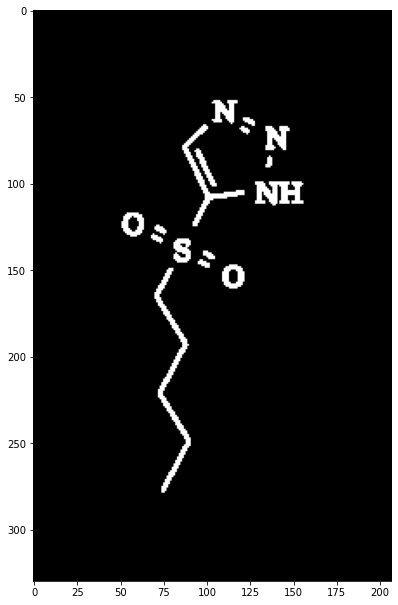

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
+-------------------------------------------------------------------------------
Molecule #2: 74563e8f0d85: InChI=1S/C8H10O2/c9-7(10)8-4-2-1-3-5(8)6(4)8/h4-6H,1-3H2,(H,9,10)
Training image path: ../data/train/7/4/5/74563e8f0d85.png
Size: (249, 234)
(249, 234, 3)
255.0


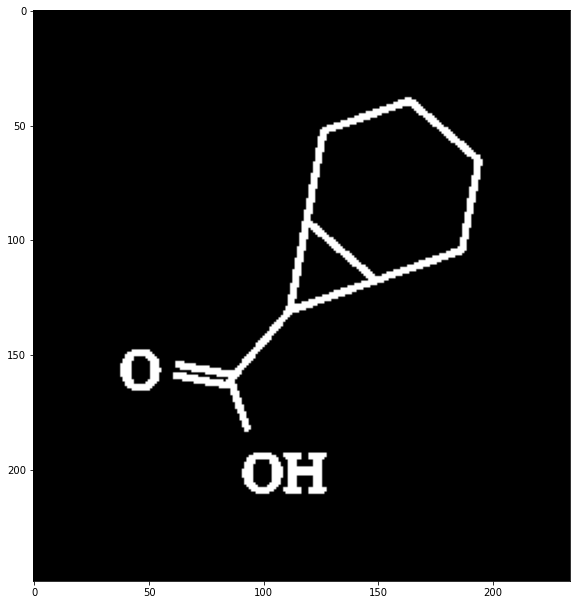

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
+-------------------------------------------------------------------------------
Molecule #3: 13179c693338: InChI=1S/C12H9BrF2N2O2S/c13-9-3-1-7(5-12(9)16)17-20(18,19)8-2-4-10(14)11(15)6-8/h1-6,17H,16H2
Training image path: ../data/train/1/3/1/13179c693338.png
Size: (399, 349)
(399, 349, 3)
255.0


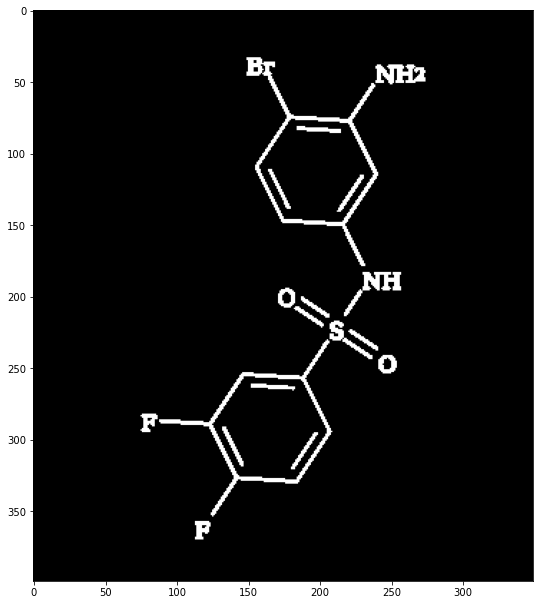

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
+-------------------------------------------------------------------------------
Molecule #4: c345d5d28316: InChI=1S/C10H12N4O3S/c1-6(18(2,15)16)9-13-10(17-14-9)7-3-4-12-8(11)5-7/h3-6H,1-2H3,(H2,11,12)
Training image path: ../data/train/c/3/4/c345d5d28316.png
Size: (275, 245)
(275, 245, 3)
255.0


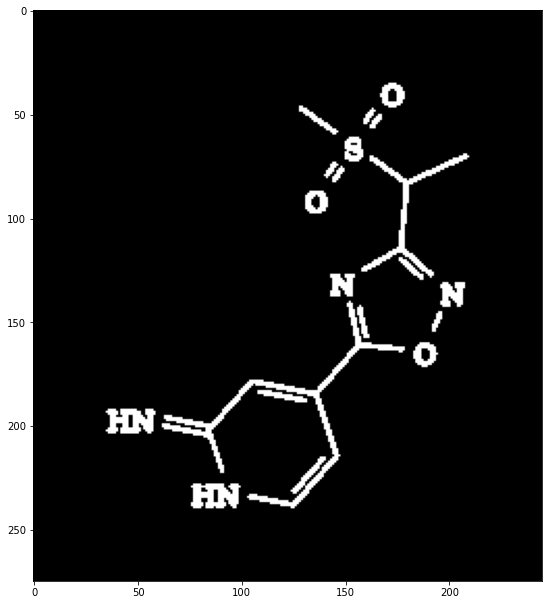

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
+-------------------------------------------------------------------------------
Molecule #5: 03d46b9d102d: InChI=1S/C22H24FN5O3S/c1-4-28-20(14(2)24-21(30)15-8-10-18(31-3)11-9-15)26-27-22(28)32-13-19(29)25-17-7-5-6-16(23)12-17/h5-12,14H,4,13H2,1-3H3,(H,24,30)(H,25,29)
Training image path: ../data/train/0/3/d/03d46b9d102d.png
Size: (367, 367)
(367, 367, 3)
255.0


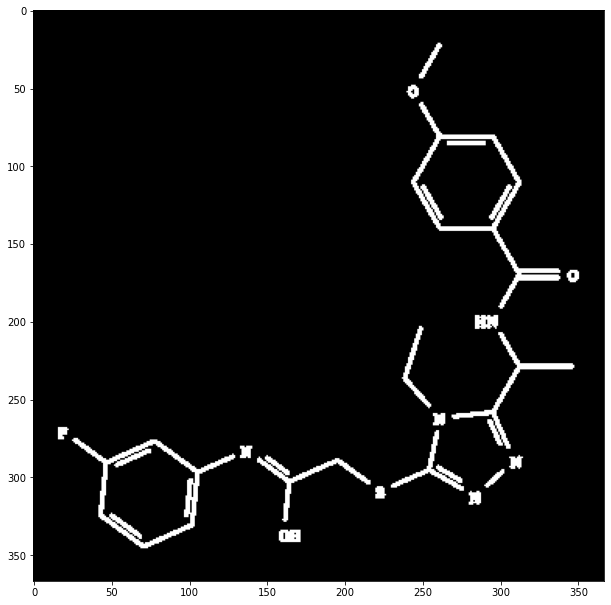

In [6]:

def test_random_molecule_image(n=4, graphics=True):
    for imol in range(n):
        #smiles = np.random.choice(some_smiles)
        mol_index = np.random.randint(len(TRAIN_LABELS))
        mol_id, inchi = TRAIN_LABELS['image_id'][mol_index], TRAIN_LABELS['InChI'][mol_index]
        mol_train_img_path = TRAIN_DATA_PATH / mol_id[0] /mol_id[1] / mol_id[2] / (mol_id + '.png')
        train_img = Image.open(mol_train_img_path)
        img, orig_bond_img, orig_atom_img = random_molecule_image(inchi)
        if graphics:
            print('+-------------------------------------------------------------------------------')
            print(f'Molecule #{imol + 1}: {mol_id}: {inchi}')
            print('Training image path:', mol_train_img_path)
            print('Size:', img.shape)
            combined_orig_img =  np.clip(np.stack([orig_atom_img, orig_bond_img, np.zeros_like(orig_bond_img)], axis=-1), 0.0, 1.0)
            combined_orig_img = (255*combined_orig_img).astype(np.uint8)
            
            #combined_orig_img = image_widget(combined_orig_img)
            combined_orig_img = np.array(combined_orig_img)
            #combined_orig_img *= 2
            new_image = combined_orig_img[:,:,0] + combined_orig_img[:,:,1] + combined_orig_img[:,:,2]
            image = np.zeros((new_image.shape[0], new_image.shape[1], 3))
            image[:,:,0] = new_image[:,:]
            image[:,:,1] = new_image[:,:]
            image[:,:,2] = new_image[:,:]
            print(image.shape)
            print(np.max(image))
            fig = plt.gcf()
            fig.set_size_inches(18.5, 10.5)
            plt.imshow(image)
            plt.show()
            #plt.figure()
            #plt.imshow(widget2)
            #plt.show()
            #plt.figure()
            #plt.imshow(train_img)
            #plt.show()
            #display(sidebyside)
            #print(f'Image from training data:')
            #print('Size:', train_img.size)
            #display(train_img)
    return

test_random_molecule_image(n=5, graphics=True)

# Save a copy from all training data

In [7]:

def make_one_image(inchi):
    img, orig_bond_img, orig_atom_img = random_molecule_image(inchi)

    combined_orig_img =  np.clip(np.stack([orig_atom_img, orig_bond_img, np.zeros_like(orig_bond_img)], axis=-1), 0.0, 1.0)
    combined_orig_img = (255*combined_orig_img).astype(np.uint8)
    
    combined_orig_img = np.array(combined_orig_img)
    new_image = combined_orig_img[:,:,0] + combined_orig_img[:,:,1] + combined_orig_img[:,:,2]
    return new_image

def save_one_image(data):
    mol_id, inchi = data[0], data[1]
    mol_train_img_path = TRAIN_DATA_PATH / mol_id[0] /mol_id[1] / mol_id[2] / (mol_id + '.png')
    train_img = Image.open(mol_train_img_path)
    img = make_one_image(inchi)
    save_img_path = SAVE_DATA_PATH / mol_id[0] /mol_id[1] / mol_id[2] / (mol_id + '.png')
    save_img_path = str(save_img_path)

    if not os.path.exists(f'../data/{TARGET_DIR}/{mol_id[0]}'):
        os.makedirs(f'../data/{TARGET_DIR}/{mol_id[0]}')
    if not os.path.exists(f'../data/{TARGET_DIR}/{mol_id[0]}/{mol_id[1]}'):
        os.makedirs(f'../data/{TARGET_DIR}/{mol_id[0]}/{mol_id[1]}')
    if not os.path.exists(f'../data/{TARGET_DIR}/{mol_id[0]}/{mol_id[1]}/{mol_id[2]}'):
        os.makedirs(f'../data/{TARGET_DIR}/{mol_id[0]}/{mol_id[1]}/{mol_id[2]}')
    #print(save_img_path)
    cv2.imwrite(save_img_path, img)

In [8]:
from multiprocessing import Pool
import time

TRAIN_LABELS_IDS = TRAIN_LABELS['image_id']
TRAIN_LABELS_INCHI = TRAIN_LABELS['InChI']
start_time = time.time()
print('start processing the train data')
train_pool = Pool()
train_pool.map(save_one_image, zip(TRAIN_LABELS_IDS, TRAIN_LABELS_INCHI))
train_pool.close()
train_pool.join()
end_time = time.time()
print('finish processing the train data')
print('Used', end_time - start_time, 'seconds')

start processing the train data
RDKit WARNING: [00:30:42] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Missing, Attachment points)
RDKit WARNING: [01:52:48] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Charge(s): Do not match)
RDKit WARNING: [03:57:24] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Falsely present, Attachment points)
RDKit WARNING: [04:32:35] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: One instead of multiple, Attachment points, Number)
RDKit WARNING: [04:59:11] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)
RDKit WARNING: [05:38:48] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)
RDKit WARNING: [10:47:54] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: One instead of multiple, Attachment points, Number)
RDKit WARNING: